In [2]:
import pandas as pd
import numpy as np

/var/folders/sp/pv6m55cn0cnf_540z_5jtfgr0000gn/T/ipykernel_1653/2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [90]:
from ipynb.fs.full.exploration_cleaning import get_data, get_paths
data = get_data()

### Difference between weekday and weekend.

In [4]:
# Turn strings in to pandas date.
data['Date'] = pd.to_datetime(data['Date'], yearfirst = True)
# Get the day of the week for each date.
data['dayofweek'] = data['Date'].dt.dayofweek
data.head()

/var/folders/sp/pv6m55cn0cnf_540z_5jtfgr0000gn/T/ipykernel_1653/3191454190.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'], yearfirst = True)


,Station or stop,Date,Number of train rides,Minutes of delay,Name,Country,Coordinate Latitude,Coordinate Longitude,dayofweek
0,80197079,2016-03-16,39,49,KINDSBACH,DEUTSCHLAND,49.420450,7.613668,2
1,80160168,2016-11-01,12,0,NIEDERTREBRA,DEUTSCHLAND,51.065500,11.580700,1
2,80105122,2016-04-30,16,2,HAMM FELDMARK,DEUTSCHLAND,51.697611,7.787870,5
3,80190793,2016-07-31,14,0,LUDWIGSHAFEN (RHEIN) BASF,DEUTSCHLAND,49.510682,8.428922,6
4,80231464,2016-05-04,10,2,BURGKEMNITZ,DEUTSCHLAND,51.689400,12.407990,2


In [5]:
data_weekday = data.loc[data['dayofweek'].isin([0, 1, 2, 3, 4])]
data_weekend = data.loc[data['dayofweek'].isin([5, 6])]

<Axes: >

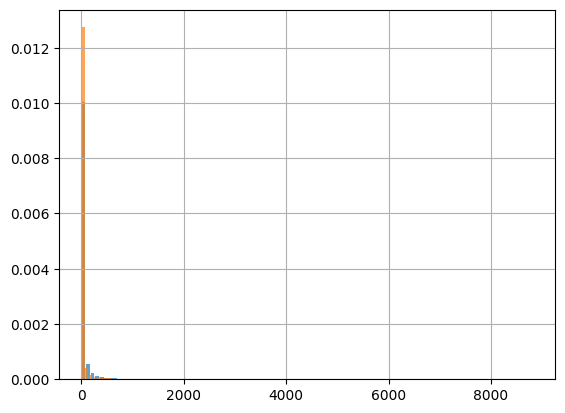

In [6]:
data_weekday["Minutes of delay"].hist(bins = 100, rwidth = 0.8, density = True, alpha = .7)
data_weekend["Minutes of delay"].hist(bins = 100, rwidth = 0.8, density = True, alpha = .7)

<Axes: >

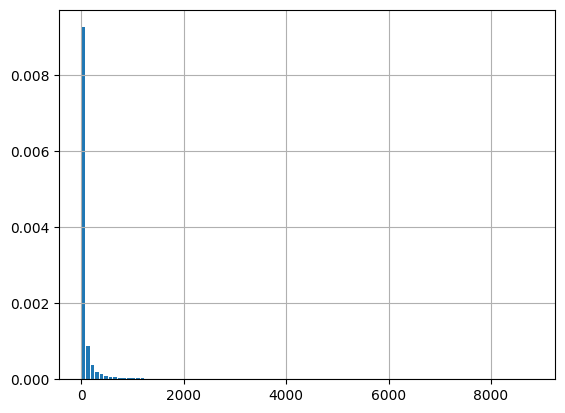

In [7]:
data_weekday[data_weekday["Minutes of delay"] != 0]["Minutes of delay"].hist(bins = 100, rwidth = 0.8, density = True)

<Axes: >

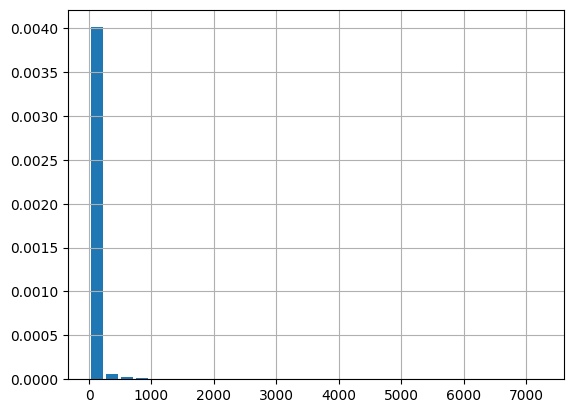

In [8]:
data_weekend["Minutes of delay"].hist(bins = 30, rwidth = 0.8, density = True)

In [9]:
data_weekday

,Station or stop,Date,Number of train rides,Minutes of delay,Name,Country,Coordinate Latitude,Coordinate Longitude,dayofweek
0,80197079,2016-03-16,39,49,KINDSBACH,DEUTSCHLAND,49.420450,7.613668,2
1,80160168,2016-11-01,12,0,NIEDERTREBRA,DEUTSCHLAND,51.065500,11.580700,1
4,80231464,2016-05-04,10,2,BURGKEMNITZ,DEUTSCHLAND,51.689400,12.407990,2
5,80020644,2016-10-04,34,0,HERBERTSHOFEN,DEUTSCHLAND,48.529570,10.849300,1
6,80042267,2016-04-15,43,116,HOSENA,DEUTSCHLAND,51.454332,14.017600,4
...,...,...,...,...,...,...,...,...,...
766023,80136234,2016-10-26,82,0,UELZEN,DEUTSCHLAND,52.964129,10.546461,2
766024,80100388,2016-01-29,33,2,HERNE,DEUTSCHLAND,51.542128,7.211104,4
766025,80143321,2016-05-30,40,0,KOLLMARSREUTE,DEUTSCHLAND,48.099070,7.887097,0
766026,80174508,2016-07-05,14,0,NEUKIRCHEN (B SULZBACH-ROSENBERG),DEUTSCHLAND,49.525068,11.620659,1


#### Calculate mean for every station by weekday or weekend

In [10]:
data_weekday_mean = data_weekday.groupby('Station or stop')['Minutes of delay'].mean()
data_weekend_mean = data_weekend.groupby('Station or stop')['Minutes of delay'].mean()
data_by_weekday_weekend = pd.merge(data_weekday_mean, data_weekend_mean, how = "left", on = "Station or stop", suffixes = ("_weekday", "_weekend"))

In [11]:
data_by_weekday_weekend.idxmax()

Minutes of delay_weekday    80031732
Minutes of delay_weekend    80031732
dtype: int64

In [12]:
diff_weekday_weekend = (data_by_weekday_weekend["Minutes of delay_weekday"] - data_by_weekday_weekend["Minutes of delay_weekend"])
diff_weekday_weekend2 = diff_weekday_weekend.drop(diff_weekday_weekend.idxmax())

<Axes: >

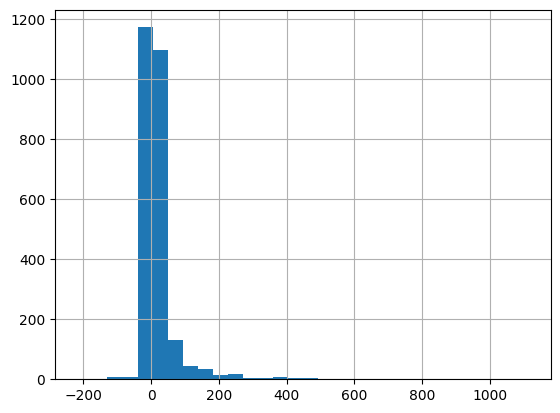

In [13]:
diff_weekday_weekend.hist(bins=30)

<Axes: >

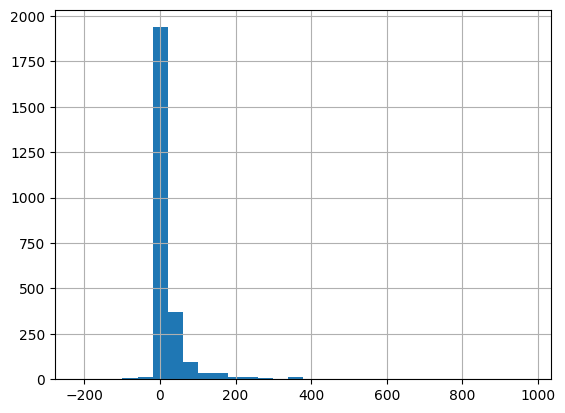

In [14]:
diff_weekday_weekend2.hist(bins=30)

In [15]:
from tueplots import bundles
from tueplots.constants.color import rgb
from matplotlib import ticker
import matplotlib.pyplot as plt

TODO: Use mean over all stations of weekend / weekday

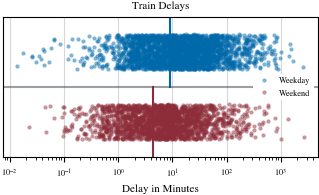

In [16]:
plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))

fig, ax = plt.subplots()
ax.set_title("Train Delays")
ax.set_xlabel("Delay in Minutes")

N = data_by_weekday_weekend.shape[0] # number of stations

np.random.seed(1)
u_we = u_wd = np.random.rand(N)

ax.plot(
    data_by_weekday_weekend["Minutes of delay_weekday"], 1 + 0.5 * u_wd, "o", label="Weekday", color=rgb.tue_blue, alpha=0.5, mec = "none", ms = 3
)
ax.plot(
    data_by_weekday_weekend["Minutes of delay_weekend"], 0.5 * u_we, "o", label="Weekend", color=rgb.tue_red, alpha=0.5, mec = "none", ms = 3
)

ax.axvline(x=data_by_weekday_weekend["Minutes of delay_weekend"].median(), ymax = 0.5, color=rgb.tue_red)
ax.axvline(x=data_by_weekday_weekend["Minutes of delay_weekday"].median(), ymin = 0.5, color=rgb.tue_blue)

# set the x-axis formatter to the custom function
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.legend(loc = 'center right', framealpha = 1.0, facecolor = 'white', edgecolor = 'none')
ax.grid(axis = 'x', which = 'major', alpha = 0.5)
ax.yaxis.set_visible(False)
ax.axhline(0.75, color = rgb.tue_dark, alpha = 0.5)
ax.set_ylim(-0.25, 1.75)
ax.set_xscale('log')

plt.show()

In [17]:
n_we = data_weekend.shape[0] # number of weekends
n_wd = data_weekday.shape[0] # number of weekdays

N = n_we + n_we # total number of days
Y = np.concatenate([data_weekend['Minutes of delay'].values, data_weekday['Minutes of delay'].values]) # all delay times, shape = (1, N)
X = np.bool_(np.concatenate([np.ones(n_we),np.zeros(n_wd)])) # TRUE if girl, FALSE otherwise, shape = (1, N)

In [18]:
rng = np.random.default_rng(1) # random number generator
B = 4000 # number of permuations to produce

# repeat Y (one row) B times, shape now = (B, N), then shuffle the columns
X_permuted = rng.permuted(np.tile(X, (B,1)), axis=1) 

In [19]:
def T_mean(group):
    '''How much faster is the average girl?'''
    return np.mean(Y[~group]) - np.mean(Y[group])

# the statistics for the original data
mean_true = T_mean(X)

# the statistics for the permuted data
mean_dist = np.apply_along_axis(T_mean, 1, X_permuted)

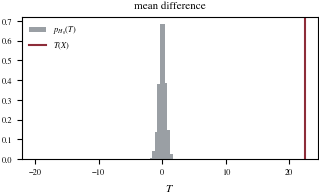

In [20]:
fig, ax = plt.subplots()

bins = np.linspace(-20, 20, 101)
ax.set_title('mean difference')
ax.hist(mean_dist, bins=bins, density=True, label='$p_{H_0}(T)$', alpha=0.5, color=rgb.tue_dark)
ax.axvline(mean_true, label='$T(X)$', alpha=1.0, color=rgb.tue_red)
ax.legend(loc='upper left', frameon=False)
#ax.yaxis.set_visible(False)
ax.set_xlabel('$T$')

plt.show()

In [21]:
bins = np.linspace(-40, 40, 101)
loc_data = np.argmax(bins >= mean_true)
histogram,_ = np.histogram(mean_dist, bins=bins, density=True)
empirical_cdf = np.cumsum(histogram) / np.sum(histogram)

p_value = empirical_cdf[loc_data]
print(p_value)

1.0000000000000002


In [22]:
data_weekday["Minutes of delay"].mean()

53.94466240891017

In [23]:
data_weekend["Minutes of delay"].mean()

31.541367788508694

In [24]:
Y = np.concatenate([data_weekend["Minutes of delay"].values, data_weekday["Minutes of delay"].values]) # all race times, shape = (1, N)
rng = np.random.default_rng(1) # random number generator
B = 100000 # number of permuations to produce

Text(0.5, 0, '$T$')

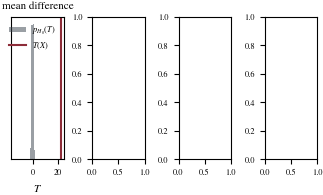

In [25]:
fig, axs = plt.subplots(1,4)

ax = axs[0]
bins = np.linspace(-15, 15, 31)
ax.set_title('mean difference')
ax.hist(mean_dist, bins=bins, density=True, label='$p_{H_0}(T)$', alpha=0.5, color=rgb.tue_dark)
ax.axvline(mean_true, label='$T(X)$', alpha=1.0, color=rgb.tue_red)
ax.legend(loc='upper right', frameon=False)
ax.yaxis.set_visible(False)
ax.set_xlabel('$T$')

### Make visualisations for each path

In [96]:
paths = get_paths(sorted = True)

TypeError: get_paths() got an unexpected keyword argument 'sorted'

In [93]:
paths_sorted = sorted(paths.items(), key = lambda x: x[1]["mean_delay"])

In [94]:
print(paths_sorted[0][1]["routes"])
print(paths_sorted[0][1]["mean_delay"])

[4801, 4080, 4020, 3522, 3603]
21.74441228493327


In [80]:
for k, v in dict(paths_sorted).items():
    if v["routes"] == [4801, 4812, 4080, 4004, 4010]:
        print(v["mean_delay"])

29.078882294757666


In [70]:
print(data_by_weekday_weekend[data_by_weekday_weekend.index.isin(paths_sorted[2][1]["stations"])]["Minutes of delay_weekday"])
print(data_by_weekday_weekend[data_by_weekday_weekend.index.isin(paths_sorted[2][1]["stations"])]["Minutes of delay_weekend"].isna())
print(paths_sorted[2][1]["mean_delay"])
(data_by_weekday_weekend[data_by_weekday_weekend.index.isin(paths_sorted[2][1]["stations"])]["Minutes of delay_weekday"] + 
 data_by_weekday_weekend[data_by_weekday_weekend.index.isin(paths_sorted[2][1]["stations"])]["Minutes of delay_weekend"].isna())

Station or stop
80106948      7.807512
80110155     39.257692
80110999      1.615385
80111062      4.750000
80111187      1.820513
80111195      1.333333
80111203     44.377778
80111229      2.575758
80114728     66.054545
80117119      3.841121
80141465      0.000000
80142620      2.167513
80142786      2.051724
80142877      1.072626
80143909      0.500000
80144147      1.740566
80145615     13.213930
80145623      0.000000
80145631      0.000000
80145672      0.000000
80147116     19.662281
80178368      1.612903
80180919     65.087336
80190512     67.836689
80190561     31.264151
80190579      1.292453
80190587     15.203791
80190595      5.488152
80190603      3.105263
80190611      5.429245
80190637      1.924883
80190645      1.720379
80190728      9.897321
80190736     17.718750
80190777    179.600877
80290155     21.030568
80290163     31.008734
80297770      3.315000
80297788      3.125628
80297846     10.609756
80297853      1.361702
80298034      4.859903
Name: Minutes of d

Station or stop
80106948      7.807512
80110155     39.257692
80110999      2.615385
80111062      4.750000
80111187      1.820513
80111195      1.333333
80111203     44.377778
80111229      2.575758
80114728     66.054545
80117119      3.841121
80141465      1.000000
80142620      3.167513
80142786      3.051724
80142877      2.072626
80143909      1.500000
80144147      1.740566
80145615     14.213930
80145623      0.000000
80145631      0.000000
80145672      0.000000
80147116     19.662281
80178368      1.612903
80180919     65.087336
80190512     67.836689
80190561     31.264151
80190579      1.292453
80190587     15.203791
80190595      5.488152
80190603      3.105263
80190611      5.429245
80190637      1.924883
80190645      1.720379
80190728      9.897321
80190736     17.718750
80190777    179.600877
80290155     21.030568
80290163     31.008734
80297770      4.315000
80297788      4.125628
80297846     11.609756
80297853      2.361702
80298034      4.859903
dtype: float64

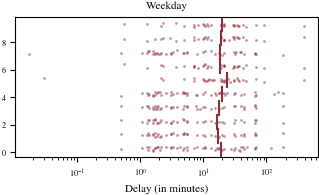

In [43]:
fig, ax = plt.subplots()
ax.set_title("Weekday")
ax.set_xlabel("Delay (in minutes)")

for i in np.arange(10):
    u_wd = np.random.rand(data_by_weekday_weekend[data_by_weekday_weekend.index.isin(paths_sorted[i][1]["stations"])]["Minutes of delay_weekday"].shape[0])
    wd = data_by_weekday_weekend[data_by_weekday_weekend.index.isin(paths_sorted[i][1]["stations"])]["Minutes of delay_weekday"]
    ax.plot(wd, 0.1 + 0.3 * u_wd + i, "o", color=rgb.tue_red, alpha=0.5, mec = "none", ms = 2)
    ax.axvline(x=data_by_weekday_weekend[data_by_weekday_weekend.index.isin(paths_sorted[i][1]["stations"])]["Minutes of delay_weekday"].mean(), 
               ymin= i * 0.1, ymax = (i + 1) * 0.1, color=rgb.tue_red)

ax.set_xscale('log')

fig.savefig("../doc/fig/plot_FP_01_Weekday.pdf")

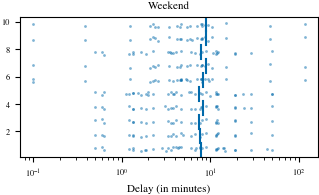

In [50]:
fig, ax = plt.subplots()
ax.set_title("Weekend")
ax.set_xlabel("Delay (in minutes)")

for i in np.arange(10):
    u_we = np.random.rand(data_by_weekday_weekend[data_by_weekday_weekend.index.isin(paths_sorted[i][1]["stations"])]["Minutes of delay_weekend"].shape[0])
    we = data_by_weekday_weekend[data_by_weekday_weekend.index.isin(paths_sorted[i][1]["stations"])]["Minutes of delay_weekend"]
    ax.plot(we, 0.6 + 0.3 * u_we + i, "o", color=rgb.tue_blue, alpha=0.5, mec = "none", ms = 2)
    ax.axvline(x=data_by_weekday_weekend[data_by_weekday_weekend.index.isin(paths_sorted[i][1]["stations"])]["Minutes of delay_weekend"].mean(), 
               ymin= i * 0.1, ymax = (i + 1) * 0.1, color=rgb.tue_blue)


ax.set_xscale('log')

fig.savefig("../doc/fig/plot_FP_01_Weekend.pdf")

In [30]:
data_by_weekday_weekend[data_by_weekday_weekend.index.isin(paths_sorted[0][1]["stations"])]["Minutes of delay_weekday"]

Station or stop
80042358      0.000000
80106948      7.807512
80110155     39.257692
80110999      1.615385
80111062      4.750000
80111187      1.820513
80111195      1.333333
80111203     44.377778
80111229      2.575758
80114728     66.054545
80117119      3.841121
80140517    118.888393
80140624     36.209607
80140640      0.000000
80140665     48.288210
80140673      0.000000
80140699      0.000000
80140707     16.314410
80141465      0.000000
80142281     27.104651
80142349     10.756881
80142356     16.949772
80142364      0.000000
80142372      7.109589
80142620      2.167513
80142786      2.051724
80142877      1.072626
80143909      0.500000
80144147      1.740566
80145615     13.213930
80145649     37.659389
80145664      4.339535
80147116     19.662281
80178368      1.612903
80180919     65.087336
80181321     43.109170
80190512     67.836689
80190561     31.264151
80190579      1.292453
80190587     15.203791
80190595      5.488152
80190603      3.105263
80190611      5.42